In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface.full as si
from sparsesorter.models.nss import NSS
from sparsesorter.utils.metrics import compute_fscore_evolution
from sparsesorter.utils.dataloader import build_dataloader
from pathlib import Path

data_path = Path("../data")

### Load Dataset

In [2]:
ds_file = data_path / "TS1.h5"
dataset, dataloader = build_dataloader(ds_file)
print("Loaded Spike Wafeforms: ", dataset["wvs"].shape)

Loaded Spike Wafeforms:  (8303, 120)


### Init NSS

In [3]:
nss = NSS(
    input_size=dataset["wvs"].shape[1],
    net_size=[120, 10],
    threshold=0.03,
    gamma=0.05,
    lr=0.07,
    bit_width=2,
)

### Fit & transform 
NSS process batch of 16 detected and pre-processed spike waveforms

In [4]:
nss_out, n_spikes = nss.fit_transform(dataloader)
sorted_spikes = np.argmax(nss_out, axis=1).astype(int)  # select most active neuron
packet_size = 400
spike_processed, fscore_nss_packet = compute_fscore_evolution(
    sorted_spikes, dataset, packet_size
)

100%|██████████| 519/519 [00:20<00:00, 25.34it/s]


In [7]:
fscore_nss_packet[:, 5:].mean(axis=1)

array([0.47558466, 0.75796589, 0.96771662, 0.71501143, 0.74760952])

### FIG4.A : Plot evolution of NSS F1-score

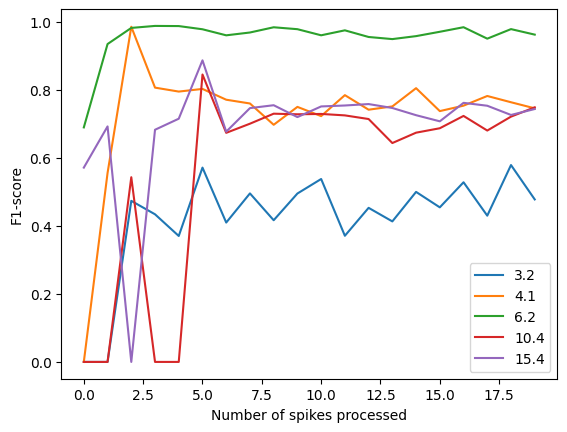

In [5]:
# plot the fscore for each packet of 100 detected spikes processed by the NSS
fig, ax = plt.subplots()
# sort by snr
idx = np.argsort(dataset["snr"])
fscore_nss_packet = fscore_nss_packet[idx]
ax.plot(fscore_nss_packet.T)
ax.legend(dataset["snr"][idx].round(1))
ax.set_xlabel("Number of spikes processed")
ax.set_ylabel("F1-score")
plt.show()

### FIG3 : Recording Trace, Ground Truth Raster and Inferred raster

Load recording trace and align the trace from one channel with the ground truth raster and inferred raster by NSS to get the Fig3.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pathlib import Path
from sparsesorter.utils.metrics import SortingMetrics

figures_path = Path("../figures")
plt.style.use("seaborn-v0_8-paper")


def plot_nss_output(nss_out, dataset, rec_f, detection_th):

    sorted_spikes = np.argmax(nss_out, axis=1).astype(int)  # select most active neuron
    gtsort_comp = SortingMetrics(
        sorted_spikes,
        dataset["raster"],
        dataset["gt_raster"],
        dataset["fs"],
        delta_time=1,
    )
    sorting_perf = gtsort_comp.get_sorting_perf(match_mode="hungarian")
    best_match_12 = sorting_perf.best_match_12
    natoms_out = nss_out.shape[1]

    fs = rec_f.get_sampling_frequency()
    nneurons = np.unique(dataset["gt_raster"][1]).shape[0]
    nchan = rec_f.get_num_channels()

    fig = plt.figure(figsize=(6, 7), dpi=150)
    time_range = (75, 80)  # time range in s
    t = np.arange(time_range[0], time_range[1], 1 / fs)
    peaks_train = dataset["raster"]
    mask_trange = (peaks_train >= time_range[0] * fs) & (
        peaks_train < time_range[1] * fs
    )
    peaks = peaks_train[mask_trange]
    trace = rec_f.get_traces()[int(time_range[0] * fs) : int(time_range[1] * fs), :]
    min_trace, max_trace = np.min(trace) - 10, np.max(trace) + 10

    gs = gridspec.GridSpec(6, 1, height_ratios=[0.1, 0.1, 0.1, 0.1, 0.15, 0.4])
    # create a subplot of 4 rows and 1 column with gs[0:3]
    ax03 = [plt.subplot(gs[i]) for i in range(4)]
    ax1 = plt.subplot(gs[4])
    ax2 = plt.subplot(gs[5])
    for ch in range(nchan):
        trace_ch = rec_f.get_traces()[
            int(time_range[0] * fs) : int(time_range[1] * fs), ch
        ]
        ax03[ch].plot(t, trace_ch, c="k", alpha=0.5)  # trace
        ax03[ch].axhline(
            -detection_th[ch], c="k", linestyle="--"
        )  # detection threshold
        ax03[ch].spines[["bottom", "top", "right"]].set_visible(False)
        ax03[ch].set_xticks([])
        ax03[ch].set_ylim(min_trace, max_trace)
        ax03[ch].set_ylabel(f"Ch{ch+1}")
        for p in peaks:
            win_width = 3 * fs // 1000
            trace_window = rec_f.get_traces()[
                p - int(0.4 * win_width) : p + int(0.6 * win_width), :
            ]
            p -= int(time_range[0] * fs)
            max_chan = np.argmax(np.max(np.abs(trace_window), axis=0))
            if max_chan == ch:
                t_window = t[p - int(0.4 * win_width) : p + int(0.6 * win_width)]
                ax03[ch].plot(t_window, trace_window[:, ch], c="k")

    peaks = peaks - int(time_range[0] * fs)
    # plot gt_raster_train on the same time range
    gtr_train = dataset["gt_raster"]
    gtr_train = gtr_train[
        :, (gtr_train[0] >= time_range[0] * fs) & (gtr_train[0] < time_range[1] * fs)
    ]
    c_unit = plt.cm.Set1(np.linspace(0, 1, 9))
    for i in range(nneurons):
        idx = np.where(gtr_train[1] == i)[0]
        ax1.vlines(gtr_train[0][idx] / fs, i - 0.4, i + 0.4, color=c_unit[i], lw=0.8)
    ax1.set_ylabel("Ground Truth")
    ax1.spines[["bottom", "top", "right"]].set_visible(False)
    ax1.set_yticks(np.arange(0, nneurons, 1))
    # ax1.set_yticklabels([])
    ax1.set_xticks([])

    # plot pred_raster on the same time range
    c_out_nss = plt.cm.tab10(np.linspace(0, 1, 10))
    for i, out_i in enumerate(nss_out[mask_trange]):
        peak_i = peaks[i]
        atom_active = len(out_i) - np.argmax(out_i)
        ax2.vlines(peak_i / fs, atom_active - 0.4, atom_active + 0.4, color="k", lw=0.8)
    ax2.set_ylabel("Inferred Raster - NSS")
    ax2.spines[["top", "right"]].set_visible(False)
    # set y-ticks at every 1 unit but label at every 2 units
    ax2.set_yticks(np.arange(1, natoms_out + 1, 1))
    ax2.set_yticklabels([])
    ax2.tick_params(axis="y", which="major")
    ax2.set_yticks(np.arange(1, natoms_out + 1, 2), minor=True)
    ax2.set_yticklabels(np.arange(1, natoms_out + 1, 2), minor=True)
    ax2.tick_params(axis="y", which="minor", labelsize=8)
    ax2.set_xticks(np.arange(t[0], t[-1] + 1, 1) - t[0])
    ax2.set_xticklabels(np.arange(t[0], t[-1] + 1, 1, dtype=int))
    ax2.set_xlabel("Time (s)")

    # draw a rectangle around the vlines of the atom 0
    for ni in range(nneurons):
        pos_y = nss_out.shape[1] - best_match_12[ni] - 0.4
        len_x = time_range[1] - time_range[0]
        ax2.add_patch(
            plt.Rectangle(
                (0, pos_y), len_x + 0.1, 0.8, fill=False, edgecolor=c_unit[ni], lw=1
            )
        )
    plt.savefig(figures_path / "fig3.svg")
    plt.show()

In [ ]:
# get trace and waveforms
rec_f = si.load_extractor(data_path / "TS1_recording")  # TR1_recording
mads = si.get_noise_levels(rec_f, return_scaled=False)
detection_th = 5 * mads

In [ ]:
plot_nss_output(nss_out, dataset, rec_f, detection_th)